Implementation of 2D gridworld from [Zorowitz et al.](https://pubmed.ncbi.nlm.nih.gov/34036174/) 

Written at NYCPW 2024

## Imports

In [1]:
!pip install palettable

zsh:1: command not found: pip


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
from scipy.spatial.distance import cdist
from pandas import DataFrame

## Object Definitions

In [4]:
def softmax(arr):
    """Scale-robust softmax choice rule."""
    arr = np.array(arr)
    arr = np.exp(arr - np.max(arr))
    return arr / arr.sum()

def pessimism(arr, w):
    """Pessimistic learning rule."""
    return w * np.max(arr) + (1 - w) * np.min(arr)

def categorical(arr):
    """Categorical distribution rng."""
    return np.argmax(np.random.multinomial(1,arr))

def grid_to_adj(grid, terminal=False):
    """Convert grid world to adjacency matrix.

    Parameters
    ----------
    grid : array, shape (i,j)
        Grid world.
    terminal : array
        List of terminal states.

    Returns
    -------
    T : array, shape (n_states, n_states)
        Adjacency matrix of states.

    Notes
    -----
    The initial grid can contain any value. Grid states defined as NaNs
    are treated as nonviable states and excluded from further processing.
    """

    ## Identify coordinates of viable states.
    rr = np.array(np.where(~np.isnan(grid))).T

    ## Compute adjacency matrix.
    A = (cdist(rr,rr)==1).astype(int)

    ## Define one-step transition matrix.
    T = np.where(A, 1, np.nan)

    ## Update terminal states.
    if np.any(terminal):
        T[terminal] = np.nan
        T[terminal,terminal] = 1

    return T

class OpenField():
    """Open field task environment.

    Parameters
    ----------
    reward : float
        Value of reward.
    punishment : float
        Value of punishment.

    Attributes
    ----------
    states : array, shape = (n,)
        Indices of states.
    n_states : int
        Total number of states.
    viable_states : array
        Indices of viable states.
    n_viable_states : int
        Number of viable states.
    info : DataFrame
        Pandas DataFrame storing the dynamics of the Markov decision process.
        Rows correspond to each viable Q-value, whereas each column contains
        its associated information.

    """

    def __init__(self,rvals=None,epsilon=0):

        ## Define gridworld.
        self.grid = np.arange(11 * 11, dtype=int).reshape(11,11)
        self.shape = self.grid.shape

        ## Define start/terminal states.
        start = 115
        # terminal = np.array([13,19])
        terminal = np.array([rloc for rloc,_ in rvals])

        ## Define one-step transition matrix.
        T = grid_to_adj(self.grid, terminal)

        ## Define rewards.
        R = 0 * np.ones_like(T)               # Majority transitions

        for iReward in range(len(rvals)):
          rloc,rval = rvals[iReward]
          R[:,rloc] = rval
          R[rloc,rloc] = 0

        # R[:,13] = reward                      # Reward transition
        # R[:,19] = 113                  # Punishment transition
        # R[terminal,terminal] = 0              # Terminal transitions
        R *= T

        ## Initialize GridWorld.
        ## Define start / terminal states.
        self.start = start
        self.terminal = terminal

        ## Define state information.
        self.states = np.arange(T.shape[0])
        self.n_states = self.states.size

        self.viable_states = self.states[~np.in1d(self.states, self.terminal)]
        self.n_viable_states = self.viable_states.size

        ## Iteratively define MDP information.
        info = []
        for s in range(self.n_states):

            ## Observe information.
            s_prime, = np.where(~np.isnan(T[s]))
            r = R[s, s_prime]
            t = np.append(1-epsilon, np.ones(r.size-1)*epsilon)

            ## Iteratively append.
            for i in range(s_prime.size):
                info.append({ "S":s, "S'":np.roll(s_prime,i), "R":np.roll(r,i), "T":t })

        ## Store.
        self.info = DataFrame(info, columns=("S","S'","R","T"))


    def __repr__(self):
        return '<GraphWorld | Open Field Task>'

    def plot_field(self, reward=10, punishment=-10, annot=True, grid_color='0.8',
                   reward_color='#f3e1db', punishment_color='#1c142a',
                   cbar=False, annot_kws=None, ax=None):
        """Plot open field environment.

        Parameters
        ----------
        reward : float
            Reward value.
        punishment : float
            Punishment value.
        annot : bool
            Annotate states.
        grid_color : str
            Color of grid tiles.
        reward_color : str
            Color of rewarding tile.
        punishment_color : str
            Color of punishing tile.
        cbar : bool
            Whether to draw a colorbar.
        annot_kws : dict of key, value mappings, optional
            Keyword arguments for ax.text when annot is True.
        ax : matplotlib Axes
            Axes in which to draw the plot.

        Returns
        -------
        ax : matplotlib Axes
            Axes in which to draw the plot.
        """

        import matplotlib.pyplot as plt
        import seaborn as sns
        from matplotlib.colors import ListedColormap

        ## Initialize canvas.
        if ax is None: fig, ax = plt.subplots(1,1,figsize=(5,5))

        ## Define grid.
        grid = np.zeros((11, 11))    # Viable states
        grid[1,[2,-3]] = [1, 2]      # Reward/punishment states

        ## Define colormap.
        cmap = ListedColormap([grid_color, reward_color, punishment_color])

        ## Plot open field.
        ax = sns.heatmap(grid, cmap=cmap, cbar=cbar, ax=ax)
        ax.set(xticklabels=[], yticklabels=[])

        ## Add outline.
        ax.vlines(np.arange(1,11),0,11,lw=0.1)
        ax.hlines(np.arange(1,11),0,11,lw=0.1)

        ## Annotate.
        if annot:
            if annot_kws is None: annot_kws = dict()
            ax.text(2.5,1.5,reward,ha='center',va='center',**annot_kws)
            ax.text(8.45,1.5,punishment,ha='center',va='center',**annot_kws)

        return ax

    def plot_policy(self, ax, pi, color='w', head_width=0.25, head_length=0.25):
        """Plot agent policy on grid world.

        Parameters
        ----------
        ax : matplotlib Axes
            Axes in which to draw the plot.
        pi : array
            Agent policy, i.e. ordered visitation of states.
        color : str, list
            Color(s) of arrow.
        head_width : float (default=0.25)
            Width of the arrow head.
        head_length : float (default=0.25)
            Length of the arrow head.

        Returns
        -------
        ax : matplotlib Axes
            Axes in which to draw the plot.
        """

        ## Error-catching.
        if isinstance(color, str):
            color = [color] * len(pi)

        ## Iteratively plot arrows.
        for i in range(len(pi)-1):

            ## Identify S, S' coordinates.
            y1, x1 = np.where(self.grid==pi[i])
            y2, x2 = np.where(self.grid==pi[i+1])

            ## Define arrow coordinates.
            x, y = int(x1) + 0.5, int(y1) + 0.5
            dx, dy = 0.5*int(x2-x1), 0.5*int(y2-y1)

            ## Plot.
            ax.arrow(x, y, dx, dy, color=color[i], head_width=head_width, head_length=head_length)

        return ax

class ValueIteration(object):
    """Q-value iteration algorithm.

    Parameters
    ----------
    policy : max | min | softmax | pessimism (default = pessimism)
        Learning rule.
    gamma : float (default = 0.9)
        Temporal discounting factor.
    beta : float (default = 10.0)
        Inverse temperature for future choice (ignored if policy not softmax).
    w : float (default = 1.0)
        Pessimism weight (ignored if policy not pessimism).
    tol : float, default: 1e-4
        Tolerance for stopping criteria.
    max_iter : int, default: 100
        Maximum number of iterations taken for the solvers to converge.

    References
    ----------
    1. Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction. MIT press.
    """

    def __init__(self, policy='pessimism', gamma=0.9, beta=10.0, w=1.0, tol=0.0001, max_iter=100):

        ## Define choice policy.
        self.policy = policy
        if policy == 'max': self._policy = np.max
        elif policy == 'min': self._policy = np.min
        elif policy == 'softmax': self._policy = lambda arr: arr @ softmax(arr * self.beta)
        elif policy == 'pessimism': self._policy = lambda arr: pessimism(arr, self.w)
        else: raise ValueError('Policy "%s" not valid!' %self.policy)

        ## Check parameters.
        self.gamma = gamma
        self.beta = beta
        self.w = w

        ## Set convergence criteria.
        self.tol = tol
        self.max_iter = max_iter

    def __repr__(self):
        return '<Q-value iteration>'

    def copy(self):
        """Return copy of agent."""
        return deepcopy(self)

    def _q_solve(self, info, Q=None):
        """Solve for Q-values iteratively."""

        ## Initialize Q-values.
        if Q is None: Q = np.zeros(info.shape[0], dtype=float)
        assert np.equal(Q.shape, info.shape[0])
        copy = info.copy()

        ## Main loop.
        for k in range(self.max_iter):

            ## Make copy.
            q = Q.copy()

            ## Precompute successor value.
            copy['Q'] = q
            V_prime = copy.groupby('S').Q.apply(self._policy).values

            ## Compute Q-values.
            for i in range(info.shape[0]):

                ## Update Q-value.
                Q[i] = sum(info.loc[i,"T"] * (info.loc[i,"R"] + self.gamma * V_prime[info.loc[i,"S'"]]))

            ## Compute delta.
            delta = np.abs(Q - q)

            ## Check for termination.
            if np.all(delta < self.tol): break

        return Q, k + 1

    def _v_solve(self, info):
        """Compute state value from Q-table."""

        ## Copy info and append Q-values.
        copy = info.copy()
        copy['Q'] = self.Q

        ## Identify max by state.
        return copy.groupby('S').Q.max().values

    def _pi_solve(self, gym):
        """Compute policy from Q-table."""

        ## Precompute optimal q(s,a).
        copy = gym.info.copy()
        copy['Q'] = self.Q
        copy = copy.iloc[copy.groupby('S').Q.idxmax().values]
        copy["S'"] = copy["S'"].apply(lambda arr: arr[0])

        ## Initialize policy from initial state.
        policy = [gym.start]

        ## Iterately append.
        while True:

            ## Termination check.
            s = policy[-1]
            if s in gym.terminal: break

            ## Observe successor.
            s_prime, = copy.loc[copy["S"]==s, "S'"].values

            ## Terminate on loops. Otherwise append.
            if s_prime in policy: break
            policy.append(s_prime)

        return policy

    def fit(self, gym, Q=None, verbose=True):
        """Solve for optimal policy.

        Parameters
        ----------
        gym : GridWorld instance
            Simulation environment.

        Returns
        -------
        self : returns an instance of self.
        """

        ## Solve for Q-values.
        self.Q, self.n_iter = self._q_solve(gym.info, Q)
        if np.equal(self.n_iter, self.max_iter) and verbose:
            print('Reached maximum iterations.')

        ## Solve for values.
        self.V = self._v_solve(gym.info)

        ## Compute policy.
        self.pi = self._pi_solve(gym)

        return self

<ipython-input-3-0b4ea5676f49>:234: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x, y = int(x1) + 0.5, int(y1) + 0.5
<ipython-input-3-0b4ea5676f49>:235: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dx, dy = 0.5*int(x2-x1), 0.5*int(y2-y1)


Reached maximum iterations.


<ipython-input-3-0b4ea5676f49>:234: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x, y = int(x1) + 0.5, int(y1) + 0.5
<ipython-input-3-0b4ea5676f49>:235: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dx, dy = 0.5*int(x2-x1), 0.5*int(y2-y1)
<ipython-input-3-0b4ea5676f49>:234: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x, y = int(x1) + 0.5, int(y1) + 0.5
<ipython-input-3-0b4ea5676f49>:235: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is dep

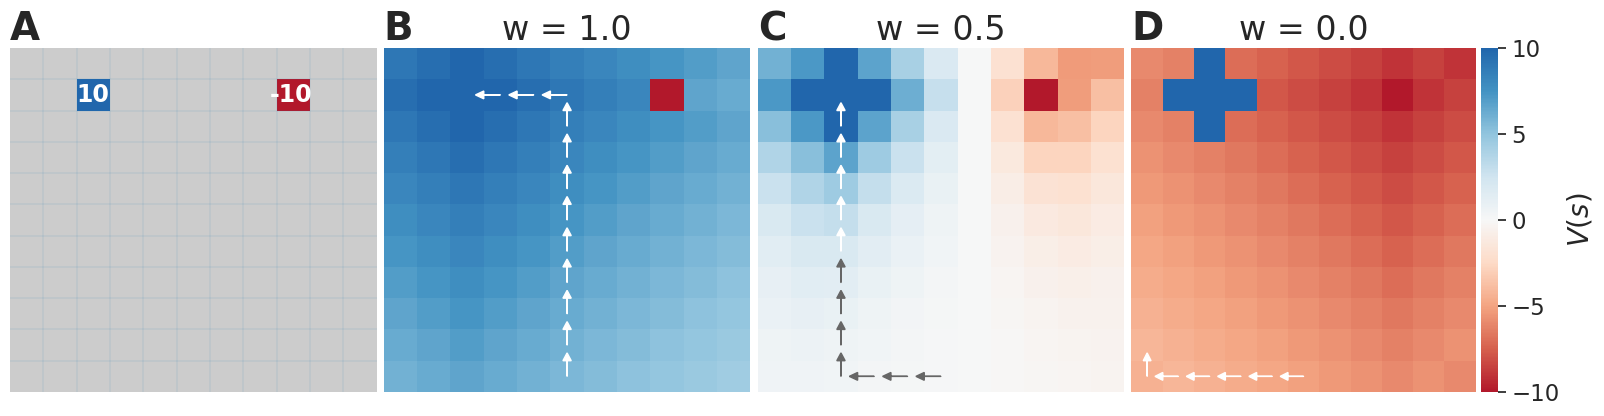

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from palettable.colorbrewer.diverging import RdBu_9 as palette
def find_2d_index_from_1d(index, ncols=11):
    row = index // ncols
    col = index % ncols
    return row, col

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Simulation parameters.
weights = [1.0, 0.5, 0.0]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Environment setup and visualization.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize figure.
fig = plt.figure(figsize=(16,4))
cmap = palette.get_mpl_colormap()
colors = palette.hex_colors

## Initialize plots and divider.
gs = gridspec.GridSpec(1,4)
gs.update(left=0.01, right=0.94, bottom=0.04, top=0.9, hspace=0, wspace=0.02)

## Initialize environment.
rvals = [(13,10),(19,-10)]
gym = OpenField(rvals=rvals)

## Plot environment.
ax = plt.subplot(gs[0])
ax = gym.plot_field(reward_color=colors[-1], punishment_color=colors[0], ax=ax,
                    annot_kws=dict(fontsize=17,fontweight='semibold',color='w'))
ax.text(0,0,'A',ha='left',va='bottom',fontsize=28,fontweight='bold')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Value iteration and visualization.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

for i, (w, label) in enumerate(zip(weights, ['B','C','D'])):

    ## Initialize value iteration.
    qvi = ValueIteration(policy='pessimism', gamma=0.95, w=w)

    ## Solve for Q-values.
    qvi = qvi.fit(gym)
    V = qvi.V.reshape(gym.shape)
    for rloc,rval in rvals:
      rloc_xy = find_2d_index_from_1d(rloc)
      V[rloc_xy[0],rloc_xy[1]] = rval

    # V[1,[2,-3]] = [10,-10] # Fill in terminal states.
    ## Solve for policy.
    pi = qvi.pi

    ## Initialize canvas.
    ax = plt.subplot(gs[i+1])
    if i == 2:
        cbar = True
        divider = make_axes_locatable(ax)
        cbar_ax = divider.append_axes("right", size="5%", pad=0.05)
    else:
        cbar = False
        cbar_ax = None

    ## Plotting.
    sns.heatmap(V, cmap=cmap, center=0, vmin=-10, vmax=10, cbar=cbar,
                xticklabels=[], yticklabels=[], ax=ax, cbar_ax=cbar_ax)
    ax = gym.plot_policy(ax, pi, color=np.where(np.abs(V.flatten()[pi]) < 2, '0.4', 'w'))
    ax.set_title(f'w = {w}', fontsize=24)
    ax.text(0,0,label,ha='left',va='bottom',fontsize=28,fontweight='bold')

    ## Update colorbar.
    if cbar:
        cbar = ax.collections[0].colorbar
        cbar.set_label(r'$V(s)$', fontsize=20)


In [ ]:

find_2d_index_from_1d(13)

(1, 2)

In [ ]:
# def run(weights=[1.0, 0.5, 0.0], rvals=[(13,10), (19,-10)]):
#     ## Simulation parameters.

#   #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#   ### Environment setup and visualization.
#   #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

#   ## Initialize figure.
#   fig = plt.figure(figsize=(16,len(weights)+1))
#   cmap = palette.get_mpl_colormap()
#   colors = palette.hex_colors

#   ## Initialize plots and divider.
#   gs = gridspec.GridSpec(1,4)
#   gs.update(left=0.01, right=0.94, bottom=0.04, top=0.9, hspace=0, wspace=0.02)

#   ## Initialize environment.
#   gym = OpenField(rvals=rvals)

#   ## Plot environment.
#   ax = plt.subplot(gs[0])
#   ax = gym.plot_field(reward_color=colors[-1], punishment_color=colors[0], ax=ax,
#                       annot_kws=dict(fontsize=17,fontweight='semibold',color='w'))
#   ax.text(0,0,'A',ha='left',va='bottom',fontsize=28,fontweight='bold')

#   #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#   ### Value iteration and visualization.
#   #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

#   for i, (w, label) in enumerate(zip(weights, ['B','C','D'])):

#       ## Initialize value iteration.
#       qvi = ValueIteration(policy='pessimism', gamma=0.95, w=w)

#       ## Solve for Q-values.
#       qvi = qvi.fit(gym)
#       V = qvi.V.reshape(gym.shape)
#       for rloc,rval in rvals:
#         rloc_xy = find_2d_index_from_1d(rloc)
#         V[rloc_xy[0],rloc_xy[1]] = rval

#       # V[1,[2,-3]] = [10,-10] # Fill in terminal states.
#       ## Solve for policy.
#       pi = qvi.pi

#       ## Initialize canvas.
#       ax = plt.subplot(gs[i+1])
#       if i == 2:
#           cbar = True
#           divider = make_axes_locatable(ax)
#           cbar_ax = divider.append_axes("right", size="5%", pad=0.05)
#       else:
#           cbar = False
#           cbar_ax = None

#       ## Plotting.
#       sns.heatmap(V, cmap=cmap, center=0, vmin=-10, vmax=10, cbar=cbar,
#                   xticklabels=[], yticklabels=[], ax=ax, cbar_ax=cbar_ax)
#       ax = gym.plot_policy(ax, pi, color=np.where(np.abs(V.flatten()[pi]) < 2, '0.4', 'w'))
#       ax.set_title(f'w = {w}', fontsize=24)
#       ax.text(0,0,label,ha='left',va='bottom',fontsize=28,fontweight='bold')

#       ## Update colorbar.
#       if cbar:
#           cbar = ax.collections[0].colorbar
#           cbar.set_label(r'$V(s)$', fontsize=20)

In [ ]:
def find_1d_from_2d(row, col, ncols=11):
    return row * ncols + col

def find_2d_index_from_1d(index, ncols=11):
    row = index // ncols
    col = index % ncols
    return row, col

def remap(reward_list, n_cols=11):
    locations = [(v[0], v[1]) for v in reward_list]
    oned_index = [find_1d_from_2d(loc[0], loc[1]) for loc in locations]
    oned_index_rewards = [(oned_index[i], reward_list[i][-1]) for i in range(len(reward_list))]
    return oned_index_rewards

In [ ]:
def run(weights=[1.0, 0.5, 0.2, 0.0], rvals=[(1, 1,10), (1, 2,-10)]):
    ## Simulation parameters.

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
  ### Environment setup and visualization.
  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
  rvals = remap(rvals)
  ## Initialize figure.
  fig = plt.figure(figsize=(len(weights)*24 / 4, 96))
  cmap = palette.get_mpl_colormap()
  colors = palette.hex_colors

  ## Initialize plots and divider.
  gs = gridspec.GridSpec(len(weights), 4)
  gs.update(left=0.01, right=0.94, bottom=0.04, top=0.9, hspace=0, wspace=0.02)

  ## Initialize environment.
  gym = OpenField(rvals=rvals)

  # ## Plot environment.
  # ax = plt.subplot(gs[0])
  # ax = gym.plot_field(reward_color=colors[-1], punishment_color=colors[0], ax=ax,
  #                     annot_kws=dict(fontsize=17,fontweight='semibold',color='w'))
  # ax.text(0,0,'A',ha='left',va='bottom',fontsize=28,fontweight='bold')

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
  ### Value iteration and visualization.
  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

  for i, (w, label) in enumerate(zip(weights, ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O'])):

      ## Initialize value iteration.
      qvi = ValueIteration(policy='pessimism', gamma=0.95, w=w)

      ## Solve for Q-values.
      qvi = qvi.fit(gym)
      V = qvi.V.reshape(gym.shape)
      for rloc,rval in rvals:
        rloc_xy = find_2d_index_from_1d(rloc)
        V[rloc_xy[0],rloc_xy[1]] = rval

      # V[1,[2,-3]] = [10,-10] # Fill in terminal states.
      ## Solve for policy.
      pi = qvi.pi

      ## Initialize canvas.
      ax = plt.subplot(gs[i])
      if i == len(weights)-1:
          cbar = True
          divider = make_axes_locatable(ax)
          cbar_ax = divider.append_axes("right", size="5%", pad=0.05)
      else:
          cbar = False
          cbar_ax = None

      ## Plotting.
      sns.heatmap(V, cmap=cmap, center=0, vmin=-10, vmax=10, cbar=cbar,
                  xticklabels=[], yticklabels=[], ax=ax, cbar_ax=cbar_ax)
      ax = gym.plot_policy(ax, pi, color=np.where(np.abs(V.flatten()[pi]) < 2, '0.4', 'w'))
      ax.set_title(f'w = {w}', fontsize=48)
      ax.text(0,0,label,ha='left',va='bottom',fontsize=48,fontweight='bold')

      ## Update colorbar.
      if cbar:
          cbar = ax.collections[0].colorbar
          cbar.set_label(r'$V(s)$', fontsize=40)
      if i == len(weights) - 1:
        break
  plt.show()

<ipython-input-3-0b4ea5676f49>:234: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x, y = int(x1) + 0.5, int(y1) + 0.5
<ipython-input-3-0b4ea5676f49>:235: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dx, dy = 0.5*int(x2-x1), 0.5*int(y2-y1)
<ipython-input-3-0b4ea5676f49>:234: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x, y = int(x1) + 0.5, int(y1) + 0.5
<ipython-input-3-0b4ea5676f49>:235: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is dep

Reached maximum iterations.


<ipython-input-3-0b4ea5676f49>:234: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x, y = int(x1) + 0.5, int(y1) + 0.5
<ipython-input-3-0b4ea5676f49>:235: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dx, dy = 0.5*int(x2-x1), 0.5*int(y2-y1)


Reached maximum iterations.


<ipython-input-3-0b4ea5676f49>:234: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x, y = int(x1) + 0.5, int(y1) + 0.5
<ipython-input-3-0b4ea5676f49>:235: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dx, dy = 0.5*int(x2-x1), 0.5*int(y2-y1)


Reached maximum iterations.


<ipython-input-3-0b4ea5676f49>:234: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x, y = int(x1) + 0.5, int(y1) + 0.5
<ipython-input-3-0b4ea5676f49>:235: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dx, dy = 0.5*int(x2-x1), 0.5*int(y2-y1)
<ipython-input-3-0b4ea5676f49>:234: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x, y = int(x1) + 0.5, int(y1) + 0.5
<ipython-input-3-0b4ea5676f49>:235: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is dep

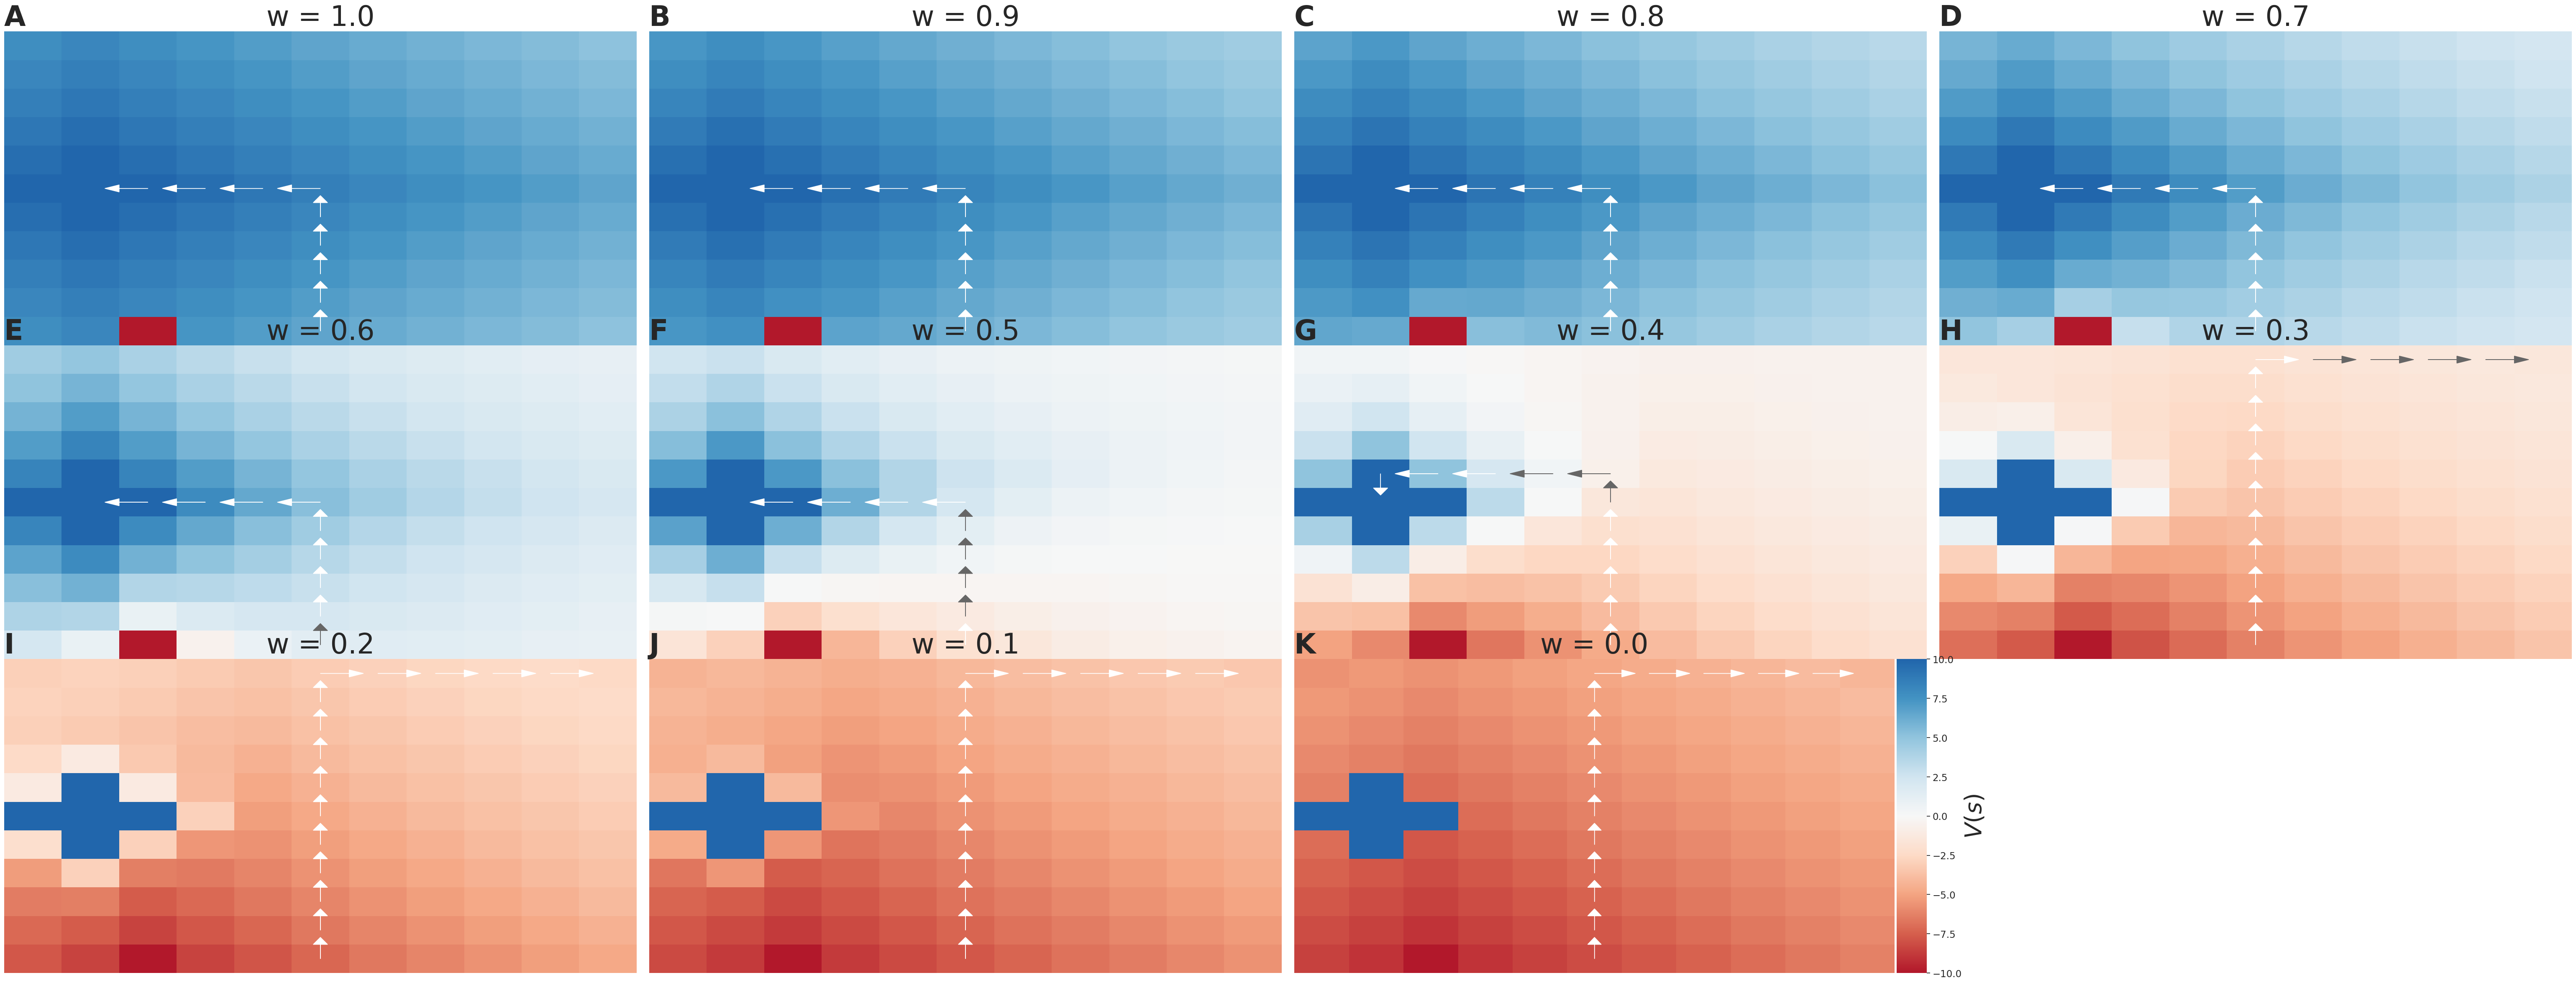

In [ ]:
run(weights = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0], rvals=[(5, 1,10), (10, 2,-10)])
# rvals (x, y, reward)